# Setup

### Imports

In [1]:
# built-ins
import os
import json
import math
import time
import pickle
import traceback
from os import path
from pathlib import Path
from datetime import datetime

# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# misc
from IPython.display import display, clear_output, Markdown
from termcolor import colored

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA

# metrics
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# training
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier

### Initial tasks

In [2]:
# allow multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import sys, os, warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# also suppress warnings of parallel processes such as grid search cv
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
# configure pandas
pd.set_option("display.max_columns", None)

### Utils / Helpers

In [3]:
def merge(a, b):
    return {**a, **b}

def cprint(text, color):
    print(colored(text, color, attrs=['bold']))
    
def print_red(text):
    cprint(text, 'red')

def print_blue(text):
    cprint(text, 'blue')

### Path Definitions

In [4]:
path_root = '.'
path_dataset = path.join(path_root, 'dataset')
path_csv = path.join(path_dataset, 'csv')
path_csv_output =  path_csv
path_models = path.join(path_root, 'models')
    
# Create directories.
Path(path_models).mkdir(parents=True, exist_ok=True)

In [5]:
class PrintDuration(object):
    class printer(str):
        def __repr__(self):
            return self
        
    def __enter__(self):
        self.start_time = datetime.now()
        self.last_tick = self.start_time
        self.tick_count = 0
        self.tick_times = 0
        
        self.completed = False
        self.progress = 0
        self.ert = 0
        self.att = 0
        self.out = None
        
        return self.tick
  
    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        
        self.completed = True
        self.render()
        
    def tdformat(self, seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))
    
    def render(self):
        output = ''
        
        if self.completed:
            complete_time = (datetime.now() - self.start_time).total_seconds()
            complete_time = self.tdformat(complete_time)
            output = f'100% completed, total run time = {complete_time}'
        else:
            percent = round(self.progress * 100)
            att = self.tdformat(self.att)
            ert = self.tdformat(self.ert)
            output = f'{percent}% completed, remaining time = {ert}, avg ticktime = {att}'
        
        output = self.printer(output)
        
        if self.out is None:
            self.out = display(output, display_id=True)
        else:
            self.out.update(output)
    
    def tick(self, progress):
        now = datetime.now()
        
        # calculate
        work_time = (now - self.start_time).total_seconds()
        tick_time = (now - self.last_tick).total_seconds()
        self.tick_count += 1
        self.tick_times += tick_time
        avg_tick_time = self.tick_times // self.tick_count
        
        if progress > 0:
            total_ticks = self.tick_count // progress
            remained_ticks = total_ticks - self.tick_count
            est_remain_time = avg_tick_time * remained_ticks
        else:
            est_remain_time = 0
            
        # set
        self.progress = progress
        self.att = avg_tick_time
        self.ert = est_remain_time
        
        # render
        self.render() 

### Detect Env

In [6]:
ENV_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None

### Path Definitions

In [7]:
path_root = '.'
path_dataset = path.join(path_root, 'dataset')
path_csv = path.join(path_dataset, 'csv')
path_csv_output =  path_csv
path_models = path.join(path_root, 'models')

if ENV_KAGGLE:
    path_root = '/kaggle/working'
    path_dataset = '/kaggle'
    path_csv = path.join(path_dataset, 'csv')
    path_csv_output = path_root
    path_models = path.join(path_root, 'models')
    
# Create directories.
Path(path_models).mkdir(parents=True, exist_ok=True)

### Configs

In [8]:
cfg_autosave_models = False
cfg_force_train = False

if ENV_KAGGLE:
    cfg_autosave_models = True
    cfg_force_train = False

# Hyperparameters

In [9]:
hp_seed = 7908
hp_cv_splits = 10
hp_test_size = 0.2

# Preprocessing

In [10]:
# read csv
data = pd.read_csv(path.join(path_csv, 'data.csv'), encoding='utf-8')

# limit data
data = data.loc[:100]

### Simple EDA

In [11]:
data.shape
data.info()

(101, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      101 non-null    object 
 1   BMI               101 non-null    float64
 2   Smoking           101 non-null    object 
 3   AlcoholDrinking   101 non-null    object 
 4   Stroke            101 non-null    object 
 5   PhysicalHealth    101 non-null    float64
 6   MentalHealth      101 non-null    float64
 7   DiffWalking       101 non-null    object 
 8   Sex               101 non-null    object 
 9   AgeCategory       101 non-null    object 
 10  Race              101 non-null    object 
 11  Diabetic          101 non-null    object 
 12  PhysicalActivity  101 non-null    object 
 13  GenHealth         101 non-null    object 
 14  SleepTime         101 non-null    float64
 15  Asthma            101 non-null    object 
 16  KidneyDisease     101 non-null    object 
 1

In [12]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,101.0,27.806931,5.820894,16.6,23.96,27.37,30.67,46.52
PhysicalHealth,101.0,5.811881,9.564218,0.0,0.00,0.00,6.00,30.00
MentalHealth,101.0,3.603960,7.976314,0.0,0.00,0.00,3.00,30.00
SleepTime,101.0,7.306931,1.713141,4.0,6.00,7.00,8.00,15.00


In [14]:
data.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

# Pipeline Setup

In [15]:
class OutlierRemover:
    @staticmethod
    def numeric(data):
        cols = data.select_dtypes(include=['float64', 'int64']).columns.to_list()
        return OutlierRemover(cols)
    
    def __init__(self, cols):
        self.cols = cols
        self.bands = {}
    
    def fit(self, data):
        for col in self.cols:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_band = Q1 - 1.5 * IQR
            upper_band = Q3 + 1.5 * IQR
            
            self.bands[col] = (lower_band, upper_band)
    
    def transform(self, data):
        for col in self.cols:
            lower_band, upper_band = self.bands[col]
            inliers = ~((data[col] < lower_band) | (data[col] > upper_band))
            data = data[inliers]
            
        return data
            
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
class MultiLabelEncoder():
    @staticmethod
    def binary(data):
        cols = [col for col in data.columns if data[col].nunique() == 2]
        return MultiLabelEncoder(cols)
    
    def __init__(self, cols):
        self.cols = cols
        self.encoders = {col: LabelEncoder() for col in cols}
    
    def fit(self, data):
        for col in self.cols:
            self.encoders[col].fit(data[col])

    def transform(self, data):
        for col in self.cols:
            data[col] = self.encoders[col].transform(data[col])
        
        return data
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)


    
class Preprocessor:
    @staticmethod
    def params(override={}):
        defaults = {
            'target': 'HeartDisease',
            'outlier_strategy': 'all',
            'encode_labels': True,
            'onehot_encoding': ['Race', 'Diabetic'],
            'ordinal_encoding': {
                'GenHealth': ['Poor', 'Fair', 'Good', 'Very good','Excellent'],
                'AgeCategory': ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54',
                                '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']
            }
        }

        return merge(defaults, override)
    
    @staticmethod
    def process(*args, **kwargs):
        processor = Preprocessor(*args, **kwargs)
        processor.apply()
        return processor
    
    def __init__(self, data, test_index=None, train_index=None, options=None):
        if options is None:
            options = Preprocessor.params()
        
        if train_index is None:
            train_index = list(range(len(data)))
            test_index = []
        
        self.data = data
        self.test_index = np.array(test_index)
        self.train_index = np.array(train_index)
        self.options = options
        
        self.target = self.options['target']
        self.update_meta()
    
    def update_meta(self):
        self.features_mask = self.data.columns != self.target
        self.columns = self.data.columns
        self.feature_columns = self.columns[self.features_mask]
        self.has_train = self.train_index.shape[0] > 0
        self.has_test = self.test_index.shape[0] > 0
    
    @property
    def test(self):
        return self.data.loc[self.test_index]
    
    @test.setter
    def test(self, value):
        self.data.loc[self.test_index] = value
    
    @property
    def train(self):
        return self.data.loc[self.train_index]
    
    @train.setter
    def train(self, value):
        self.data.loc[self.train_index] = value

    def x(self, dframe):
        return dframe.drop(self.target, axis=1).to_numpy()
    
    def y(self, dframe):
        return dframe[self.target].to_numpy()
        
    @property
    def x_test(self):
        return self.x(self.test)
    
    @x_test.setter
    def x_test(self, value):
        self.data.loc[self.test_index, self.features_mask] = value
        
    @property
    def x_train(self):
        return self.x(self.train)
    
    @x_train.setter
    def x_train(self, value):
        self.data.loc[self.train_index, self.features_mask] = value
    
    @property
    def y_test(self):
        return self.y(self.test)
        
    @property
    def y_train(self):
        return self.y(self.train)
    
    def chop(self):
        return self.x_test, self.y_test, self.x_train, self.y_train
    
    def apply(self):
        # remove outliers
        outlier_strategy = self.options.get('outlier_strategy', 'train_only')
        outlier_remover = OutlierRemover.numeric(self.data)
        match outlier_strategy:
            case 'train_only':
                self.train = outlier_remover.fit_transform(self.train)
            case 'include_test':
                outlier_remover.fit(self.train())
                self.data = outlier_remover.transform(self.data)
            case 'all':
                self.data = outlier_remover.fit_transform(self.data)
            case 'none':
                pass
        
        # update removed indexes.
        indexes = self.data.index.values
        self.train_index = self.train_index[np.isin(self.train_index, indexes)]
        self.test_index = self.test_index[np.isin(self.test_index, indexes)]
        
        # encode labels
        encode_labels = self.options.get('encode_labels', True)
        if encode_labels:
            self.data = MultiLabelEncoder.binary(self.data).fit_transform(self.data)
            
        onehot_encoding = self.options.get('onehot_encoding', None)
        if onehot_encoding is not None:
            cols = onehot_encoding
            self.data = pd.get_dummies(self.data, columns=cols, prefix=cols)
            self.update_meta()
            
        # ordinal encoding
        ordinal_encoding = self.options.get('ordinal_encoding', None)
        if ordinal_encoding is not None:
            for col, ordinals in ordinal_encoding.items():
                encoder = OrdinalEncoder(categories=[ordinals])
                self.data[[col]] = encoder.fit_transform(self.data[[col]])
        
        # scaler
        scale = self.options.get('scale', True)
        if scale:
            scaler = StandardScaler()
            self.x_train = scaler.fit_transform(self.x_train)
            
            if self.has_test:
                self.x_test = scaler.transform(self.x_test)

In [16]:
class Model:
    def __init__(self, estimator, data, n_splits, test_size, seed,
                 prep_params=None, hp_grid=None):
        
        self.estimator = estimator
        self.data = data
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.hp_grid = hp_grid
        
        self.stats = []
        self.best_stats = None
        self.best_estimator = None
    
    def split(self):
        split = ShuffleSplit(n_splits=self.n_splits, test_size=self.test_size, random_state=self.seed)
        return split.split(self.data)
    
    def train(self, tick=None):
        for split_index, (train_index, test_index) in enumerate(self.split()):
            if tick is not None:
                tick(split_index/self.n_splits)
            
            preprocessor = Preprocessor.process(self.data, test_index, train_index, self.prep_params)
            X_test, Y_test, X_train, Y_train = preprocessor.chop()
            
            estimator = self.estimator()
            
            # default values
            best_params = None
            best_estimator = estimator
            
            # fit estimator
            if self.hp_grid is not None:
                cv = GridSearchCV(estimator, self.hp_grid, cv=self.n_splits, n_jobs=-1)
                cv.fit(X_train, Y_train)
                
                best_params = cv.best_params_
                best_estimator = cv.best_estimator_
            else:
                best_estimator.fit(X_train, Y_train)
            
            Y_pred = best_estimator.predict(X_test)
            accuracy = accuracy_score(Y_test, Y_pred)
            
            result = dict(y_true=Y_test, y_pred=Y_pred, best_params=best_params, accuracy=accuracy,
                          seed=self.seed, best_estimator=best_estimator, preprocessor=preprocessor)
            
            self.stats.append(result)
    
    def predict(self, data):
        data = data.copy()
        self.best_preprocessor.transform(data)
        return self.best_estimator.predict(data)
    
    def collect_best_stats(self):
        best_accuracy = -1
        total_accuracy = 0
        best_stats = None
        
        for stats in self.stats:
            accuracy = stats['accuracy']

            total_accuracy += accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_stats = stats
        
        self.best_stats = best_stats
        self.best_estimator = best_stats['best_estimator']
        self.best_preprocessor = best_stats['preprocessor'] 
        self.mean_accuracy = total_accuracy / len(self.stats)

In [17]:
class Trainer:   
    def __init__(self, name, data, n_splits, test_size, seed, prep_params={}):
        self.name = name
        self.data = data
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.estimators = {}
    
    def set_estimators(self, estimators):
        self.estimators = estimators
    
    def get_model_path(self, name):
        return path.join(path_models, f'{self.name}_{name}.pickle')
    
    def save_model(self, name, model):
        model_path = self.get_model_path(name)
        with open(model_path,'wb') as file:
            pickle.dump(model, file)
        
    def load_model(self, name):
        model_path = self.get_model_path(name)
        with open(model_path, 'rb') as file:
            return pickle.load(file)
        
    def train_estimators(self, **kwargs):
        estimators = kwargs.pop('estimators', self.estimators.keys())
        for name in estimators:
            print_red(f'Estimator: {name}\n')
            model = self.train_estimator(name, **kwargs)
            yield (name, model)
            
    def train_estimator(self, name, reset=False, seed=None, save=True):      
        if seed is None:
            seed = self.seed
        
        if not reset:
            try:
                model = self.load_model(name)
                setattr(self, name, model)
                
                print(f'Model {name} is loaded from disk successfully.')
                return model
            
            except:
                model = None
        
        name, estimator, hp_grid = self.estimators[name]
        model = Model(estimator, self.data, self.n_splits,
                    self.test_size, seed, self.prep_params, hp_grid)
        
        with PrintDuration() as tick:
            model.train(tick)

        model.collect_best_stats()
        setattr(self, name, model)
        
        if save:
            self.save_model(name, model)
            
        return model
    
    def search_best_seed(self, name, seed_range=100):
        best_rsme = math.inf
        best_seed = 0

        for seed in range(seed_range):
            estimator = self.train_estimator(name, seed, save=False)
            rsme = estimator.best_stats["rsme"]

            if rsme < best_rsme:
                best_rsme = rsme
                best_seed = seed
                print(f'{seed} -> {rsme} - {estimator.mean_rsme}')
        
        print(f'Best seed found as {best_seed}')
        return best_seed
    
    def get_results_dataframe(self, name, shuffle=False, ascending=False):
        model = getattr(self, name)

        true = model.best_stats['y_true'].reshape(-1)
        pred = model.best_stats['y_pred'].reshape(-1)
        
        df = pd.DataFrame(data={
            'true': true,
            'prediction': pred,
            'diff': np.absolute(true - pred)
        })
    
        if shuffle:
            df = df.sample(frac=1)
        else:
            df = df.sort_values('diff', ascending=ascending)
        
        return df
    
    def print_stats(self, name):
        model = getattr(self, name)
        print('best_accuracy', model.best_stats['accuracy'])
        print('mean_accuracy', model.mean_accuracy)
        print('best_params', model.best_stats['best_params'])

In [18]:
class SetTrainer:
    def __init__(self):
        self.estimators = {}
        self.trainer_names = []
        
    def add_estimator(self, name, estimator, hp_grid=None):
        self.estimators[name] = (name, estimator, hp_grid)
        
    def add_trainer(self, **kwargs):
        name = kwargs['name']
        trainer = Trainer(**kwargs)
        trainer.set_estimators(self.estimators)
        
        self.trainer_names.append(name)
        setattr(self, name, trainer)
        
    def run_trainer(self, name, **kwargs):
        trainer = getattr(self, name)
        for (model_name, model) in trainer.train_estimators(**kwargs):
            yield (name, trainer, model_name, model)
            
    def run_all_trainers(self, **kwargs):
        trainers = kwargs.pop('trainers', self.trainer_names)
        count = len(trainers)
        
        for index, name in enumerate(trainers):
            print_blue(f'Trainer {index+1}/{count}: {name}\n')
            for (trainer_name, trainer, model_name, model) in self.run_trainer(name, **kwargs):
                yield (trainer_name, trainer, model_name, model)
    
set_trainer = SetTrainer()

## Helper Functions

### Feature Importance

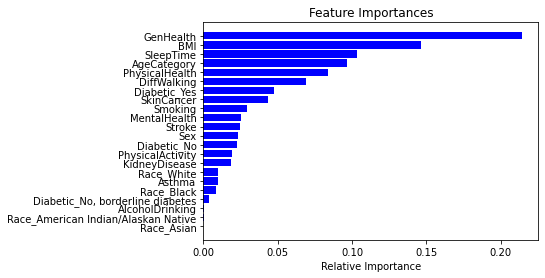

In [19]:
def calculate_feature_importances(data, n_splits, test_size, seed, prep_params=None):
    model = Model(RandomForestClassifier, data, n_splits, test_size, seed, prep_params)
    model.train()
    model.collect_best_stats()
    
    importances = model.best_estimator.feature_importances_
    indices = np.argsort(importances)
    graph_x = range(len(indices))
    
    plt.title('Feature Importances')
    plt.barh(graph_x, importances[indices], color='b', align='center')
    plt.yticks(graph_x, model.best_stats['preprocessor'].feature_columns[indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
calculate_feature_importances(data=data, n_splits=hp_cv_splits,
    test_size=hp_test_size, seed=hp_seed)

### Explained Variance Ratio

For p=95% n_components should be 17



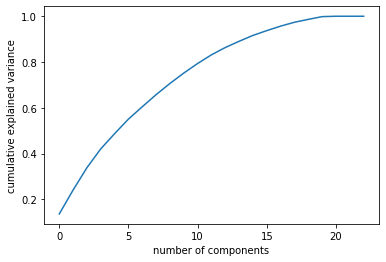

In [20]:
def calculate_explained_variance_ratio(data, p=0.95):
    X = Preprocessor.process(data).data
    
    pca = PCA(n_components=None, svd_solver='full', copy=True)
    reduced = pca.fit_transform(X)
    
    # extract the smallest number of components which
    # explain at least p% (e.g. 80%) of the variance
    n_components = 1 + np.argmax(np.cumsum(pca.explained_variance_ratio_) >= p)
    print(f'For p={int(p*100)}% n_components should be {n_components}\n')

    # extract the values of the selected components
    #Z = pca.transform(X)[:, :n_components]
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    
calculate_explained_variance_ratio(data, 0.95)

# Model Definitions

## Logistic Regression 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [21]:
# Add estimator
set_trainer.add_estimator('logistic', LogisticRegression, {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': [0.5, 1, 2],
    'solver': ['saga'],
    'max_iter': [100, 500, 1000],
})

## Gaussian Naive Bayes 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), [comparing naive bayes classification algorithms](https://towardsdatascience.com/comparing-a-variety-of-naive-bayes-classification-algorithms-fc5fa298379e)

In [22]:
# Add estimator
set_trainer.add_estimator('nb_gaussian', GaussianNB, {
    'var_smoothing': [0, 1e-10, 1e-9, 1e-8]
})

## Multinomial Naive Bayes 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [23]:
# Add estimator
set_trainer.add_estimator('nb_multinomial', MultinomialNB, {
    'alpha': [0, 0.5, 1.0, 2.0],
})

## Complement Naive Bayes 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html)

In [24]:
# Add estimator
set_trainer.add_estimator('nb_complement', ComplementNB, {
    'alpha': [0, 0.5, 1.0, 2.0],
    'norm': [True, False],
})

## Categorical Naive Bayes 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html)

In [25]:
# Add estimator
set_trainer.add_estimator('nb_categorical', CategoricalNB, {
    'alpha': [0, 0.5, 1.0, 2.0],
})

# Training

### Default Trainer

In [26]:
prep_params = Preprocessor.params({
    'outlier_strategy': 'all',
    'encode_labels': True,
})

set_trainer.add_trainer(name='default', data=data, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

### PCA Trainer

### Training

In [29]:
options = {
    # set trainer parameters
    #'trainers': [],
    
    # trainer parameters
    'estimators': ['nb_categorical'],
    #'reset': False,
    #'seed': None,
    #'save': False,
}

for (trainer_name, trainer, model_name, model) in set_trainer.run_all_trainers(**options):
    # Show stats.
    print()
    trainer.print_stats(model_name)
    print()
    
    # Show predicts.
    trainer.get_results_dataframe(model_name, ascending=True).head()

Trainer 1/1: default

Estimator: nb_categorical



100% completed, total run time = 00:00:00

Traceback (most recent call last):
  File "/var/folders/gd/fz5ntn7j5w1f7q7w_bv1zbwr0000gn/T/ipykernel_62007/634792175.py", line 54, in train_estimator
    model.train(tick)
  File "/var/folders/gd/fz5ntn7j5w1f7q7w_bv1zbwr0000gn/T/ipykernel_62007/3291261638.py", line 38, in train
    cv.fit(X_train, Y_train)
  File "/Users/ramesaliyev/Projects/Personal/ai-heart-disease-prediction/venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 875, in fit
    self._run_search(evaluate_candidates)
  File "/Users/ramesaliyev/Projects/Personal/ai-heart-disease-prediction/venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 1375, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/Users/ramesaliyev/Projects/Personal/ai-heart-disease-prediction/venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 852, in evaluate_candidates
    _warn_or_raise_about_fit_failures(out, self.error_score)
  File "/Users/ramesaliy

ValueError: 
All the 40 fits failed.
It is is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ramesaliyev/Projects/Personal/ai-heart-disease-prediction/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ramesaliyev/Projects/Personal/ai-heart-disease-prediction/venv/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 1290, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/ramesaliyev/Projects/Personal/ai-heart-disease-prediction/venv/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 699, in fit
    X, y = self._check_X_y(X, y)
  File "/Users/ramesaliyev/Projects/Personal/ai-heart-disease-prediction/venv/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 1351, in _check_X_y
    check_non_negative(X, "CategoricalNB (input X)")
  File "/Users/ramesaliyev/Projects/Personal/ai-heart-disease-prediction/venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1368, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to CategoricalNB (input X)
